In [0]:
# Mount your google drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Data Manupulation

In [0]:
# Import whatever
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import pandas_datareader.data as web

/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [0]:
# Change working directory (put everything under this path)
os.chdir("/content/drive/My Drive/Colab Notebooks/FE5225 Project/data/LOB_UPS")

In [0]:
# feature engineering during file input

def message_agg(df):
  df['size_sum'] = df['size']
  df['size_max'] = df['size']
  df['size_count'] = df['size']
  df['price_mean'] = df['price'] * df['size']
  df['price_max'] = df['price']
  df['price_min'] = df['price']
  df['price_first'] = df['price']
  df['price_last'] = df['price']
  df = df.resample('30S').agg({'size_sum': np.sum, 'size_max': np.max, 'size_count': 'count', 'price_mean': np.sum, 'price_max': np.max, 'price_min': np.min, 'price_first': 'first', 'price_last': 'last'})
  df['price_mean'] = df['price_mean'] / df['size_sum']
  # df['size_sum'] = np.log(df['size_sum'] + 1)
  # df['size_max'] = np.log(df['size_max'] + 1)
  return df

def message_fillna(df):
    df['size_sum'].fillna(value = 0, inplace = True)
    df['size_max'].fillna(value = 0, inplace = True)
    df['size_count'].fillna(value = 0, inplace = True)
    df['price_last'].fillna(method = 'ffill', inplace = True) 
    df['price_mean'].fillna(value = df['price_last'], inplace = True)  
    df['price_max'].fillna(value = df['price_last'], inplace = True)
    df['price_min'].fillna(value = df['price_last'], inplace = True)
    df['price_first'].fillna(value = df['price_last'], inplace = True)   
    return df

def orderbook_agg(df):
    df_copy = df.copy()
    df_copy["Pa1_max"] = df_copy['Pa1']
    df_copy["Pa1_min"] = df_copy['Pa1']
    df_copy["Pb1_max"] = df_copy['Pb1']
    df_copy["Pb1_min"] = df_copy['Pb1']
    df = df.resample('30S').last()
    df_copy = df_copy.resample('30S').agg({'Pa1_max': np.max, 'Pa1_min': np.min, 'Pb1_max': np.max, 'Pb1_min': np.min})
    df["Pa1_max"] = df_copy["Pa1_max"]
    df["Pa1_min"] = df_copy["Pa1_min"]
    df["Pb1_max"] = df_copy["Pb1_max"]
    df["Pb1_min"] = df_copy["Pb1_min"]
    return df

def orderbook_fillna(df, num_levels):
    for i in range(num_levels):
      df["Pa%d"%(i+1)].fillna(method = 'ffill', inplace = True)
      df["Va%d"%(i+1)].fillna(method = 'ffill', inplace = True)
      df["Pb%d"%(i+1)].fillna(method = 'ffill', inplace = True)
      df["Vb%d"%(i+1)].fillna(method = 'ffill', inplace = True)
    df['Pa1_max'].fillna(value = df['Pa1'], inplace = True)
    df['Pa1_min'].fillna(value = df['Pa1'], inplace = True)
    df['Pb1_max'].fillna(value = df['Pb1'], inplace = True)
    df['Pb1_min'].fillna(value = df['Pb1'], inplace = True)
    return df

def advanced_feature(df):
    n = 30 * 2
    
    # SMA and EWMA
    df["SMA15M"] = df["price_last"].rolling(int(n / 2), min_periods = 1).mean()
    df["SMA30M"] = df["price_last"].rolling(n, min_periods = 1).mean()
    df["SMA60M"] = df["price_last"].rolling(n * 2, min_periods = 1).mean()
    df["EWMA95"] = df["price_last"].ewm(alpha = 2 / n).mean()
    df["EWMA97"] = df["price_last"].ewm(alpha = 1 / n).mean()
    df["EWMA99"] = df["price_last"].ewm(alpha = 0.5 / n).mean()
    
    # Accumulation/distribution index (ADI)
    df["CLV"] = ((df["price_last"] - df["price_min"]) - (df["price_max"] - df["price_last"]))  / (df["price_max"] - df["price_min"] + 0.000001)
    df["ADI"] = df["CLV"] * df["size_sum"]
    df["ADI"] = df["ADI"].cumsum()
    df = df.drop(['CLV'], axis=1)

    # Typical price
    df["TP"] = (df["price_max"] + df["price_min"] + df["price_last"]) / 3
    
    # Bollinger bands
    df["BOLU"] = df["TP"].rolling(n, min_periods = 1).mean() + 2 * df["TP"].rolling(n, min_periods = 1).std()
    df["BOLU"].fillna(value = df["TP"], inplace = True)
    df["BOLD"] = df["TP"].rolling(n, min_periods = 1).mean() - 2 * df["TP"].rolling(n, min_periods = 1).std()
    df["BOLD"].fillna(value = df["TP"], inplace = True)

    # Stochastic oscillator
    df["SO"] = (df["price_last"] - df["price_last"].rolling(int(n / 2), min_periods = 1).min()) / (df["price_last"].rolling(int(n / 2), min_periods = 1).max() - df["price_last"].rolling(int(n / 2), min_periods = 1).min() + 0.000001)
    df["SO"] = 100 * (df["SO"].rolling(n, min_periods = 1).mean())

    # Relative strength index
    df["Ut"] = (df["price_last"].shift(-1) - df["price_last"]) * (df["price_last"].shift(-1) > df["price_last"])
    df["Ut"] = df["Ut"].shift(1)
    df["Ut"].fillna(method = 'bfill', inplace = True)
    df["Ut"] = df["Ut"].ewm(alpha = 1 / n).mean()
    df["Dt"] = (df["price_last"] - df["price_last"].shift(-1)) * (df["price_last"].shift(-1) < df["price_last"])
    df["Dt"] = df["Dt"].shift(1)
    df["Dt"].fillna(method = 'bfill', inplace = True)
    df["Dt"] = df["Dt"].ewm(alpha = 1 / n).mean()
    df["RSI"] = 100 - 100/(1 + (df["Ut"]/(df["Dt"] + 0.000001)))
    df = df.drop(['Ut', 'Dt'], axis=1)

    # Average directional moving index
    df["UM"] = df["price_max"].shift(-1) - df["price_max"]
    df["DM"] = df["price_min"] - df["price_min"].shift(-1)
    df["UM"] = df["UM"] * (df["UM"] > df["DM"]) * (df["UM"] > 0)
    df["DM"] = df["DM"] * (df["DM"] > df["UM"]) * (df["DM"] > 0)
    df["TR1"] = df["price_max"].shift(-1) - df["price_min"].shift(-1)
    df["TR2"] = (df["price_max"].shift(-1) - df["price_last"]).abs()
    df["TR3"] = (df["price_min"].shift(-1) - df["price_last"]).abs()
    df["TR"] = df[["TR1", "TR2", "TR3"]].max(axis = 1)
    df["UM"] = 100 * (df["UM"].ewm(alpha = 1 / n).mean() / (df["TR"].rolling(n, min_periods = 1).mean() + 0.000001))
    df["DM"] = 100 * (df["DM"].ewm(alpha = 1 / n).mean() / (df["TR"].rolling(n, min_periods = 1).mean() + 0.000001))
    df["ADX"] = ((df["UM"] - df["DM"]).abs()) / ((df["UM"] + df["DM"]).abs())
    df["ADX"] = 100 * df["ADX"].ewm(alpha = 1 / n).mean()
    df["ADX"] = df["ADX"].shift(1)
    df["ADX"].fillna(method = 'bfill', inplace = True)
    df = df.drop(['UM', 'DM', 'TR1', 'TR2', 'TR3', 'TR'], axis=1)

    return df

In [0]:
message_fileList = sorted(glob.glob("*message_10.csv"))
orderbook_fileList = sorted(glob.glob("*orderbook_10.csv"))
message_dfList = []
orderbook_dfList = []

num_levels = 10
orderbook_header_list = []
for i in range(num_levels):
    orderbook_header_list = orderbook_header_list + ["Pa%d"%(i+1),"Va%d"%(i+1),"Pb%d"%(i+1),"Vb%d"%(i+1)]

# #import daily data
# df_daily = web.DataReader("IBM", start='2017-12-29', end='2018-04-01', data_source='yahoo')

# #weekly data
# def week_open(array_like):
#     return array_like[0]
# def week_close(array_like):
#     return array_like[-1]
# df_weekly = df_daily.resample('W', how={'Open': week_open, 'High': 'max', 'Low': 'min','Close': week_close, 'Volume': 'sum'})
# df_weekly = df_weekly[['Open', 'High', 'Low', 'Close', 'Volume']]

def readNfile(start = 0, end = 61):
  orderbook_dfList = []
  message_exe_dfList = []
  message_sb_dfList = []
  message_ss_dfList = []
  message_db_dfList = []
  message_ds_dfList = []
  for i in range(start, end):
    message_newdf = pd.read_csv(message_fileList[i],usecols = [0,1,3,4,5], names=['time', 'type','size','price','direction'])
    year = int(message_fileList[i][4:8])
    month = int(message_fileList[i][9:11])
    day = int(message_fileList[i][12:14])
    message_newdf.index = pd.Timestamp(year, month, day, 0) + pd.TimedeltaIndex(message_newdf.time, unit='s')
    orderbook_newdf = pd.read_csv(orderbook_fileList[i],header=None)
    orderbook_newdf.index = message_newdf.index
    orderbook_newdf.columns = orderbook_header_list


    message_exe_newdf = message_newdf.copy()
    message_exe_newdf = message_exe_newdf[(message_exe_newdf['type'] == 4) | (message_exe_newdf['type'] == 5)]
    message_exe_newdf = message_agg(message_exe_newdf)
    message_exe_newdf = message_fillna(message_exe_newdf)
    message_exe_newdf = advanced_feature(message_exe_newdf)
    message_exe_dfList.append(message_exe_newdf)

    message_sb_newdf = message_newdf.copy()
    message_sb_newdf = message_sb_newdf[(message_sb_newdf['type'] == 1) & (message_sb_newdf['direction'] == 1)]
    message_sb_newdf = message_agg(message_sb_newdf)
    message_sb_newdf = message_fillna(message_sb_newdf)
    message_sb_dfList.append(message_sb_newdf)

    message_ss_newdf = message_newdf.copy()
    message_ss_newdf = message_ss_newdf[(message_ss_newdf['type'] == 1) & (message_ss_newdf['direction'] == -1)]
    message_ss_newdf = message_agg(message_ss_newdf)
    message_ss_newdf = message_fillna(message_ss_newdf)
    message_ss_dfList.append(message_ss_newdf)

    message_db_newdf = message_newdf.copy()
    message_db_newdf = message_db_newdf[((message_db_newdf['type'] == 2) | (message_db_newdf['type'] == 3)) & (message_db_newdf['direction'] == 1)]
    message_db_newdf = message_agg(message_db_newdf)
    message_db_newdf = message_fillna(message_db_newdf)
    message_db_dfList.append(message_db_newdf)

    message_ds_newdf = message_newdf.copy()
    message_ds_newdf = message_ds_newdf[((message_ds_newdf['type'] == 2) | (message_ds_newdf['type'] == 3)) & (message_ds_newdf['direction'] == -1)]
    message_ds_newdf = message_agg(message_ds_newdf)
    message_ds_newdf = message_fillna(message_ds_newdf)
    message_ds_dfList.append(message_ds_newdf)

    orderbook5s_newdf = orderbook_agg(orderbook_newdf)
    orderbook5s_newdf = orderbook_fillna(orderbook5s_newdf, num_levels)
    
    orderbook_dfList.append(orderbook5s_newdf)

  df_orderbook = pd.concat(orderbook_dfList, axis=0)
  df_message_exe = pd.concat(message_exe_dfList, axis=0)
  df_message_sb = pd.concat(message_sb_dfList, axis=0)
  df_message_ss = pd.concat(message_ss_dfList, axis=0)
  df_message_db = pd.concat(message_db_dfList, axis=0)
  df_message_ds = pd.concat(message_ds_dfList, axis=0)

  return df_orderbook, df_message_exe, df_message_sb, df_message_ss, df_message_db, df_message_ds


In [0]:
# #import N files
start_date = 20
end_date = 60
df_orderbook, df_message_exe, df_message_sb, df_message_ss, df_message_db, df_message_ds = readNfile(start_date, end_date)

In [0]:
display(df_orderbook.shape)
display(df_message_exe.shape)
display(df_message_sb.shape)
display(df_message_ss.shape)
display(df_message_db.shape)
display(df_message_ds.shape)
df_orderbook.head()

(31200, 44)

(31184, 21)

(31200, 8)

(31200, 8)

(31200, 8)

(31200, 8)

,Pa1,Va1,Pb1,Vb1,Pa2,Va2,Pb2,Vb2,Pa3,Va3,Pb3,Vb3,Pa4,Va4,Pb4,Vb4,Pa5,Va5,Pb5,Vb5,Pa6,Va6,Pb6,Vb6,Pa7,Va7,Pb7,Vb7,Pa8,Va8,Pb8,Vb8,Pa9,Va9,Pb9,Vb9,Pa10,Va10,Pb10,Vb10,Pa1_max,Pa1_min,Pb1_max,Pb1_min
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-31 09:30:00,1280000,400,1278700,200,1285000,100,1278600,111,1288900,100,1275000,75,1289200,111,1273700,100,1290800,100,1273500,111,1306400,100,1255000,800,1311000,300,1253700,20,1324700,800,1253200,100,1332100,100,1235700,800,1339900,100,1230400,200,1285000,1280000,1280500,1278600
2018-01-31 09:30:30,1285000,100,1280500,361,1288900,100,1279300,300,1289200,111,1278700,100,1294000,100,1278600,111,1306400,100,1275400,100,1311000,300,1275000,75,1324700,800,1273500,111,1332100,100,1255000,800,1339900,100,1253700,20,1342900,200,1253200,100,1285000,1279900,1280500,1278700
2018-01-31 09:31:00,1279800,100,1276900,109,1280200,200,1276100,100,1281800,100,1275100,285,1282400,3,1275000,75,1283800,3,1273700,3,1284900,3,1273500,111,1285000,100,1273400,100,1288900,100,1271000,1000,1289200,111,1270000,209,1290100,100,1269500,10,1285000,1279600,1282700,1276100
2018-01-31 09:31:30,1279600,300,1277700,109,1279900,100,1277200,200,1282400,3,1276100,100,1283800,3,1275100,285,1284900,3,1275000,75,1285000,100,1274800,3,1285500,200,1273700,3,1286900,200,1273500,111,1288300,200,1273400,100,1288900,100,1271800,200,1279800,1279600,1277700,1277300
2018-01-31 09:32:00,1281800,100,1280300,109,1281900,100,1279700,200,1283800,3,1279500,100,1284900,3,1277800,3,1285000,100,1276700,3,1285500,200,1275100,285,1286900,200,1275000,175,1288300,200,1274800,3,1288900,100,1273700,3,1289200,111,1273500,111,1283800,1279300,1280300,1277700


In [0]:
# #import 1 files

# orderbook = "data/LOB_IBM/IBM_2018-01-02_34200000_57600000_orderbook_10.csv"
# message = "data/LOB_IBM/IBM_2018-01-02_34200000_57600000_message_10.csv"

# #import files [direction = 1: bid / -1: ask]
# df_message = pd.read_csv(message,usecols = [0,1,3,4,5], names=['time', 'type','size','price','direction'])

# df_message.index = pd.Timestamp(2018, 1, 2, 0) + pd.TimedeltaIndex(df_message.time, unit='s') 
# df_message.head()

# num_levels = 10

# header_list = []
# for i in range(num_levels):
#     header_list = header_list + ["Pa%d"%(i+1),"Va%d"%(i+1),"Pb%d"%(i+1),"Vb%d"%(i+1)]
# df_orderbook = pd.read_csv(orderbook,header=None,names=header_list)
# df_orderbook.index = df_message.index

# df_orderbook.head()

In [0]:
#binary function: used for labelling. 
def labelling(a):
    if a > 2000:
        c = 1
    else:
        c = 0
    return c

#catagorical labelling 
def labelling_cat(a,b):
    if (a > 2000) & (a > b):
        c = 1
    else:
      if b > 2000:
        c = 2
      else:
        c = 0
    return c

# Spreads and mid-prices for each bid-ask level
def feature_v2(num_levels,df): # 20
    for i in range(1,num_levels+1):
        df["spread%d"%(i)] = df["Pa%d"%(i)] - df["Pb%d"%(i)]
        df["midprice%d"%(i)] = (df["Pa%d"%(i)] + df["Pb%d"%(i)])/2
    return df

# Price difference between adjacent bid level and ask level
def feature_v3(num_levels,df): # 20 - 2
    for i in range(1, num_levels):
        df["PA_diff%d"%(i)] = df["Pa%d"%(i+1)] - df["Pa%d"%(i)]
        df["PB_diff%d"%(i)] = df["Pb%d"%(i)] - df["Pb%d"%(i+1)]
    return df

# Average of the 4 statistics among all 10 levels 
def feature_v4(num_levels,df): # 4
    lst = ["Pa%d"%(i+1) for i in range(num_levels)]
    df["Pa_mean"] = df[df.columns.intersection(lst)].mean(axis=1)    
    
    lst = ["Pb%d"%(i+1) for i in range(num_levels)]
    df["Pb_mean"] = df[df.columns.intersection(lst)].mean(axis=1)
    
    lst = ["Va%d"%(i+1) for i in range(num_levels)]
    df["Va_mean"] = df[df.columns.intersection(lst)].mean(axis=1)
    
    lst = ["Vb%d"%(i+1) for i in range(num_levels)]
    df["Vb_mean"] = df[df.columns.intersection(lst)].mean(axis=1)
    return df

# Get cumulative difference between bid-ask pair for price and volume 
def feature_v5(num_levels,df): # 20
    for i in range(num_levels): #
        df["pri_accum_diff%d"%(i+1)] = 0
        df["vol_accum_diff%d"%(i+1)] = 0
        for k in range(i):
            df["pri_accum_diff%d"%(i+1)] += (df["Pa%d"%(k+1)] - df["Pb%d"%(k+1)])
            df["vol_accum_diff%d"%(i+1)] += (df["Va%d"%(k+1)] - df["Vb%d"%(k+1)])
    return df

# Hour and day pattern label
def feature_v6(df):
  df["weekday"] = np.vectorize(lambda x: pd.Timestamp(x).weekday())(df.index)
  df["secofday"] = np.vectorize(lambda x: pd.Timestamp(x).hour * 3600 + pd.Timestamp(x).minute * 60 + pd.Timestamp(x).second)(df.index)
  return df

# Important news label
def feature_v7(df):
  t = pd.Timestamp(2018, 2, 1, 9)
  df["earning"] = np.vectorize(lambda x: 86400/(pd.Timestamp(x) - t).total_seconds()  if ((pd.Timestamp(x) - t).total_seconds() > 0) else 0)(df.index) # 4Q17 earning report release
  t = pd.Timestamp(2018, 2, 16, 9)
  df["ex_div"] = np.vectorize(lambda x: 86400/(pd.Timestamp(x) - t).total_seconds() if ((pd.Timestamp(x) - t).total_seconds() > 0) else 0)(df.index)  # ex-dividend date
  return df

# Take log of volume terms
def feature_t1(num_levels, df):
  for i in range(num_levels):
    df["Va%d"%(i+1)] = np.log(df["Va%d"%(i+1)] + 1)
    df["Vb%d"%(i+1)] = np.log(df["Vb%d"%(i+1)] + 1)
  return df

def feature_t2(df):
  df["size"] = np.log(df["size"] + 1)
  return df

# Normalization
def normalize_input(X_train, X_test):
    scaler = StandardScaler()
    # Fit on training set only.
    scaler.fit(X_train)
    # Apply transform to both the training set and the test set.
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, X_test

# Result output
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, confusion_matrix
def model_scoring(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print("======================================")
    print("======Model Performance===============")

    print("the accuracy is: ", accuracy)
    print("the precision is：",precision)
    print("the recall is: ", recall)
    print("the f1 score is: ", f1)
    print("confution matrix: \n", confusion_matrix(y_test, y_pred))
    

In [0]:
### Generate all features

# df_orderbook = feature_v2(num_levels,df_orderbook)
# df_orderbook = feature_v3(num_levels,df_orderbook)
# df_orderbook = feature_v4(num_levels,df_orderbook)
# df_orderbook = feature_v5(num_levels,df_orderbook)
df_orderbook = feature_v6(df_orderbook)
df_orderbook = feature_v7(df_orderbook)

# df_orderbook = feature_t1(num_levels,df_orderbook)
# df_message = feature_t2(df_message)

display(df_orderbook.shape)
df_orderbook.head()


(31200, 48)

,Pa1,Va1,Pb1,Vb1,Pa2,Va2,Pb2,Vb2,Pa3,Va3,Pb3,Vb3,Pa4,Va4,Pb4,Vb4,Pa5,Va5,Pb5,Vb5,Pa6,Va6,Pb6,Vb6,Pa7,Va7,Pb7,Vb7,Pa8,Va8,Pb8,Vb8,Pa9,Va9,Pb9,Vb9,Pa10,Va10,Pb10,Vb10,Pa1_max,Pa1_min,Pb1_max,Pb1_min,weekday,secofday,earning,ex_div
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-31 09:30:00,1280000,400,1278700,200,1285000,100,1278600,111,1288900,100,1275000,75,1289200,111,1273700,100,1290800,100,1273500,111,1306400,100,1255000,800,1311000,300,1253700,20,1324700,800,1253200,100,1332100,100,1235700,800,1339900,100,1230400,200,1285000,1280000,1280500,1278600,2,34200,0,0
2018-01-31 09:30:30,1285000,100,1280500,361,1288900,100,1279300,300,1289200,111,1278700,100,1294000,100,1278600,111,1306400,100,1275400,100,1311000,300,1275000,75,1324700,800,1273500,111,1332100,100,1255000,800,1339900,100,1253700,20,1342900,200,1253200,100,1285000,1279900,1280500,1278700,2,34230,0,0
2018-01-31 09:31:00,1279800,100,1276900,109,1280200,200,1276100,100,1281800,100,1275100,285,1282400,3,1275000,75,1283800,3,1273700,3,1284900,3,1273500,111,1285000,100,1273400,100,1288900,100,1271000,1000,1289200,111,1270000,209,1290100,100,1269500,10,1285000,1279600,1282700,1276100,2,34260,0,0
2018-01-31 09:31:30,1279600,300,1277700,109,1279900,100,1277200,200,1282400,3,1276100,100,1283800,3,1275100,285,1284900,3,1275000,75,1285000,100,1274800,3,1285500,200,1273700,3,1286900,200,1273500,111,1288300,200,1273400,100,1288900,100,1271800,200,1279800,1279600,1277700,1277300,2,34290,0,0
2018-01-31 09:32:00,1281800,100,1280300,109,1281900,100,1279700,200,1283800,3,1279500,100,1284900,3,1277800,3,1285000,100,1276700,3,1285500,200,1275100,285,1286900,200,1275000,175,1288300,200,1274800,3,1288900,100,1273700,3,1289200,111,1273500,111,1283800,1279300,1280300,1277700,2,34320,0,0


In [0]:
df_final = pd.concat([df_orderbook, df_message_exe], axis=1)
df_final = message_fillna(df_final)
df_final.columns = df_orderbook.columns.append("exe_" + df_message_exe.columns)
df_copy = df_final.columns.copy()

df_final = pd.concat([df_final, df_message_sb], axis=1)
df_final = message_fillna(df_final)
df_final.columns = df_copy.append("sb_" + df_message_sb.columns)
df_copy = df_final.columns.copy()

df_final = pd.concat([df_final, df_message_ss], axis=1)
df_final = message_fillna(df_final)
df_final.columns = df_copy.append("ss_" + df_message_ss.columns)
df_copy = df_final.columns.copy()

df_final = pd.concat([df_final, df_message_db], axis=1)
df_final = message_fillna(df_final)
df_final.columns = df_copy.append("db_" + df_message_db.columns)
df_copy = df_final.columns.copy()

df_final = pd.concat([df_final, df_message_ds], axis=1)
df_final = message_fillna(df_final)
df_final.columns = df_copy.append("ds_" + df_message_ds.columns)
df_copy = df_final.columns.copy()

df_final.fillna(method = 'ffill', inplace=True)

display(df_final.shape)
df_final.tail()

(31200, 101)

,Pa1,Va1,Pb1,Vb1,Pa2,Va2,Pb2,Vb2,Pa3,Va3,Pb3,Vb3,Pa4,Va4,Pb4,Vb4,Pa5,Va5,Pb5,Vb5,Pa6,Va6,Pb6,Vb6,Pa7,Va7,Pb7,Vb7,Pa8,Va8,Pb8,Vb8,Pa9,Va9,Pb9,Vb9,Pa10,Va10,Pb10,Vb10,...,exe_EWMA99,exe_ADI,exe_TP,exe_BOLU,exe_BOLD,exe_SO,exe_RSI,exe_ADX,sb_size_sum,sb_size_max,sb_size_count,sb_price_mean,sb_price_max,sb_price_min,sb_price_first,sb_price_last,ss_size_sum,ss_size_max,ss_size_count,ss_price_mean,ss_price_max,ss_price_min,ss_price_first,ss_price_last,db_size_sum,db_size_max,db_size_count,db_price_mean,db_price_max,db_price_min,db_price_first,db_price_last,ds_size_sum,ds_size_max,ds_size_count,ds_price_mean,ds_price_max,ds_price_min,ds_price_first,ds_price_last
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-03-28 15:57:30,1028700,100,1028400,100,1028800,64,1028300,100,1029000,63,1028200,64,1029100,100,1028100,200,1029200,363,1028000,163,1029300,100,1027900,300,1029400,162,1027800,162,1029500,62,1027700,287,1029600,262,1027600,100,1029700,60,1027500,162,...,1.031603e+06,23828.137956,1.028500e+06,1.033001e+06,1.028562e+06,42.206984,45.583401,5.902417,9292,200.0,99,1.028135e+06,1028600.0,1027500.0,1028300.0,1027800.0,5249,200.0,56,1.028813e+06,1029600.0,1028300.0,1029000.0,1029100.0,8923,100.0,95,1.028107e+06,1028600.0,1027100.0,1028300.0,1028200.0,4890,100.0,56,1.028772e+06,1029600.0,1028300.0,1028700.0,1029500.0
2018-03-28 15:58:00,1028700,100,1028200,64,1028800,361,1028100,100,1029000,63,1028000,264,1029100,100,1027900,100,1029200,163,1027800,162,1029300,300,1027700,162,1029400,162,1027600,100,1029500,262,1027500,162,1029600,62,1027400,846,1029700,160,1027300,162,...,1.031578e+06,25080.137951,1.028500e+06,1.033038e+06,1.028446e+06,41.433868,45.583401,5.909547,6098,200.0,69,1.028163e+06,1028700.0,1027600.0,1028400.0,1028000.0,10498,329.0,103,1.028840e+06,1029600.0,1028300.0,1029500.0,1028800.0,5870,200.0,66,1.028115e+06,1028700.0,1027600.0,1028500.0,1028100.0,9701,329.0,97,1.028859e+06,1029600.0,1028300.0,1028700.0,1029500.0
2018-03-28 15:58:30,1028500,100,1028300,200,1028600,165,1028100,165,1028700,65,1028000,164,1028800,165,1027900,100,1028900,165,1027800,262,1029000,265,1027700,162,1029100,100,1027600,300,1029200,165,1027500,262,1029300,100,1027400,946,1029400,162,1027300,162,...,1.031553e+06,24903.137952,1.028667e+06,1.033038e+06,1.028347e+06,40.212034,45.583401,5.893073,8623,200.0,90,1.028247e+06,1029000.0,1027400.0,1028000.0,1027900.0,7720,227.0,79,1.029083e+06,1029900.0,1028400.0,1028600.0,1028800.0,7772,200.0,81,1.028272e+06,1029000.0,1027700.0,1028400.0,1027700.0,7159,297.0,69,1.029088e+06,1030000.0,1028400.0,1028700.0,1028500.0
2018-03-28 15:59:00,1028000,65,1027500,200,1028200,165,1027400,200,1028300,100,1027300,808,1028400,265,1027200,200,1028500,100,1027100,660,1028600,265,1027000,300,1028800,165,1026900,160,1028900,65,1026800,300,1029000,165,1026700,162,1029200,165,1026600,262,...,1.031521e+06,20402.137957,1.028000e+06,1.033092e+06,1.028200e+06,39.506906,44.115035,5.931848,25412,646.0,256,1.027754e+06,1028400.0,1026900.0,1027300.0,1027500.0,16854,739.0,171,1.028324e+06,1029400.0,1027700.0,1028400.0,1027800.0,24300,646.0,247,1.027756e+06,1028400.0,1026900.0,1027400.0,1027500.0,15962,739.0,163,1.028355e+06,1029400.0,1027700.0,1028400.0,1027800.0
2018-03-28 15:59:30,1027400,167,1026900,100,1027600,267,1026700,100,1027700,100,1026600,300,1027800,267,1026500,62,1027900,100,1026400,362,1028000,165,1026300,562,1028200,165,1026200,100,1028300,100,1026100,162,1028400,165,1026000,200,1028600,165,1025900,162,...,1.031481e+06,17625.137960,1.027033e+06,1.033180e+06,1.027965e+06,38.096650,42.565704,6.034588,965617,8900.0,530,1.026657e+06,1027600.0,1026000.0,1027400.0,1026700.0,19195,300.0,196,1.027487e+06,1029000.0,1026800.0,1027800.0,1028300.0,966562,8900.0,546,1.026657e+06,1027600.0,1025700.0,1027500.0,1026700.0,17794,300.0,184,1.027476e+06,1028600.0,1026800.0,1027800.0,1027000.0


In [0]:
### Generate label 
time_shift = 30
# 15分钟内可以卖平的最高价
df_final["exe_max_15min"] = df_final["exe_price_max"].rolling(time_shift).max().shift(-1*time_shift)
df_final["sb_max_15min"] = df_final["sb_price_max"].rolling(time_shift).max().shift(-1*time_shift) 
df_final["Pb_max_15min"] = df_final["Pb1_max"].rolling(time_shift).max().shift(-1*time_shift)  
df_final["sell_max_15min"] = df_final[["exe_max_15min", "sb_max_15min", "Pb_max_15min"]].max(axis = 1)
df_final = df_final.drop(['exe_max_15min', 'sb_max_15min', 'Pb_max_15min'], axis=1)

# 15分钟内可以买平的最低价
df_final["exe_min_15min"] = df_final["exe_price_min"].rolling(time_shift).min().shift(-1*time_shift)
df_final["ss_min_15min"] = df_final["ss_price_min"].rolling(time_shift).min().shift(-1*time_shift)
df_final["Pa_min_15min"] = df_final["Pa1_min"].rolling(time_shift).min().shift(-1*time_shift)
df_final["buy_min_15min"] = df_final[["exe_min_15min", "ss_min_15min", "Pa_min_15min"]].min(axis = 1)
df_final = df_final.drop(['exe_min_15min', 'ss_min_15min', 'Pa_min_15min'], axis=1)

# df_final["rollmax_15min"] = df_final["Pb1_max"].rolling(time_shift).max().shift(-time_shift) #15分钟内最高的bid
# df_final["rollmin_15min"] = df_final["Pa1_min"].rolling(time_shift).min().shift(-time_shift) #15分钟内最低的ask
df_final["long_price_change"] = df_final["sell_max_15min"] - df_final["Pa1"]
df_final["short_price_change"] = df_final["Pb1"] - df_final["buy_min_15min"]

X = df_final.drop(['sell_max_15min', 'buy_min_15min', 'long_price_change', 'short_price_change'], axis=1).values
y = np.array(list(map(labelling_cat, df_final["long_price_change"], df_final["short_price_change"]))).reshape(-1,1)
enc = OneHotEncoder(sparse=False)
y = enc.fit_transform(y)

In [0]:
display(type(X))
display(X.shape)
display(type(y))
display(y.shape)
# display(type(y1))
# display(y1.shape)
# display(np.sum(y1)/y1.shape[0])
# df_final.describe()[["long_price_change"]]
# plt.hist(df_final['long_price_change'], 20, normed=True, range=[-2000, 10000])
# plt.show()

numpy.ndarray

(31200, 101)

numpy.ndarray

(31200, 3)

In [0]:
# display(type(y2))
# display(y2.shape)
# display(np.sum(y2)/y2.shape[0])
# df_final.describe()[["short_price_change"]]
# plt.hist(df_final['short_price_change'], 20, normed=True, range=[-2000, 10000])
# plt.show()

In [0]:
# # Labelling if midprice limit order can be executed within 1 min. Used for trading strategy test (not for model training).

# Last 1 min in a day
last_min = 1 * 2

# Bid ask price after 1 min
df_final["Pa1_1min"] = df_final["Pa1"].shift(-2)
df_final["Pb1_1min"] = df_final["Pb1"].shift(-2)

# mid price
df_final["midprice"] = (df_final["Pa1"] + df_final["Pb1"]) / 2

# Buy Check (whether midprice limit buy can be executed within 1 min)
df_final["exe_min_1min"] = df_final["exe_price_min"].rolling(2).min().shift(-2)
df_final["ss_min_1min"] = df_final["ss_price_min"].rolling(2).min().shift(-2)
df_final["Pa_min_1min"] = df_final["Pa1_min"].rolling(2).min().shift(-2)
df_final["buy_min_1min"] = df_final[["exe_min_1min", "ss_min_1min", "Pa_min_1min"]].min(axis = 1)
df_final["buy_check"] = (df_final["buy_min_1min"] <= df_final["midprice"]) * 1
df_final = df_final.drop(['exe_min_1min', 'ss_min_1min', 'Pa_min_1min'], axis=1)

# Sell Check (whether midprice limit sell can be executed within 1 min)
df_final["exe_max_1min"] = df_final["exe_price_max"].rolling(2).max().shift(-2)
df_final["sb_max_1min"] = df_final["sb_price_max"].rolling(2).max().shift(-2)
df_final["Pb_max_1min"] = df_final["Pb1_max"].rolling(2).max().shift(-2)
df_final["sell_max_1min"] = df_final[["exe_max_1min", "sb_max_1min", "Pb_max_1min"]].max(axis = 1)
df_final["sell_check"] = (df_final["sell_max_1min"] >= df_final["midprice"]) * 1
df_final = df_final.drop(['exe_max_1min', 'sb_max_1min', 'Pb_max_1min'], axis=1)

#RNN_LSTM

In [0]:
# LSTM time step for 1 sample = 30 min
time_step = 60

# Sliding every 1 min
slide_step = 2

# Train-test cut
date_length = end_date - start_date
train_test_cut_date = int(date_length * 0.8)
train_test_cut = train_test_cut_date * 780

# Normalization
X_mean = np.mean(X[0:train_test_cut], axis = 0)
X_std = np.std(X[0:train_test_cut], axis = 0) + 0.00000001
X_normalize = (X - X_mean) / X_std

X_train = []
y_train = []
X_test = []
y_test = []

# Data are packed day by day. No cross day sample.
# Randomly drop some data to ensure even split among 3 catagories.
for i in range(train_test_cut_date):
  for j in range(i*780, (i+1)*780 - time_shift - time_step - last_min, slide_step):
    _y = y[j+time_step]
    if ((_y[0] == 1) & (np.random.rand() < 0.13)):
       continue
    if ((_y[2] == 1) & (np.random.rand() < 0.045)):
       continue
    _X = X_normalize[j:j+time_step]
    X_train.append(_X)
    y_train.append(_y)

train_size = len(X_train)

for i in range(train_test_cut_date, date_length):
  for j in range(i*780, (i+1)*780 - time_shift - time_step - last_min, slide_step):
    _X = X_normalize[j:j+time_step]
    _y = y[j+time_step]
    X_test.append(_X)
    y_test.append(_y)

test_size = len(X_test)

n_features = X.shape[1]
X_train = np.array(X_train)
X_train.reshape((-1, train_size, n_features))
y_train = np.array(y_train)
y_train.reshape((-1, train_size))
X_test = np.array(X_test)
X_test.reshape((-1, test_size, n_features))
y_test = np.array(y_test)
y_test.reshape((-1, test_size))

display(X_train.shape)
display(y_train.shape)
display(X_test.shape)
display(y_test.shape)
display(np.sum(y_train, axis = 0)/y_train.shape[0])
display(np.sum(y_test, axis = 0)/y_test.shape[0])

(10345, 60, 101)

(10345, 3)

(2752, 60, 101)

(2752, 3)

array([0.33465442, 0.3322378 , 0.33310778])

array([0.33502907, 0.28924419, 0.37572674])

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM
model_rnn = Sequential()
model_rnn.add(LSTM(32, return_sequences = True, input_shape = (time_step, n_features)))
model_rnn.add(Dropout(0.5))
model_rnn.add(LSTM(8, return_sequences = False, input_shape = (time_step, n_features)))
model_rnn.add(Dropout(0.5))
model_rnn.add(Dense(8, activation = 'relu'))
model_rnn.add(Dropout(0.5))
model_rnn.add(Dense(3, activation = 'softmax'))
model_rnn.summary()
model_rnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 32)            17152     
_________________________________________________________________
dropout (Dropout)            (None, 60, 32)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 1312      
_________________________________________________________________
dropout_1 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dropout_2 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 2

In [0]:
# from tensorflow.keras.callbacks import EarlyStopping
# es = EarlyStopping(mode = 'min', patience = 2)
m = model_rnn.fit(X_train, y_train, epochs = 5, verbose = 1, validation_data = (X_test, y_test))

Epoch 1/5
324/324 [==============================] - 14s 43ms/step - loss: 1.0916 - categorical_accuracy: 0.3824 - val_loss: 1.0723 - val_categorical_accuracy: 0.4430
Epoch 2/5
324/324 [==============================] - 13s 39ms/step - loss: 1.0589 - categorical_accuracy: 0.4286 - val_loss: 1.0687 - val_categorical_accuracy: 0.4291
Epoch 3/5
324/324 [==============================] - 12s 38ms/step - loss: 1.0473 - categorical_accuracy: 0.4361 - val_loss: 1.1353 - val_categorical_accuracy: 0.3583
Epoch 4/5
324/324 [==============================] - 13s 40ms/step - loss: 1.0307 - categorical_accuracy: 0.4536 - val_loss: 1.0815 - val_categorical_accuracy: 0.4084
Epoch 5/5
324/324 [==============================] - 13s 39ms/step - loss: 1.0158 - categorical_accuracy: 0.4631 - val_loss: 1.0961 - val_categorical_accuracy: 0.4259


In [0]:
y_pred = model_rnn.predict(X_test)

In [0]:
y_pred_1 = np.argmax(y_pred, axis = 1)
y_test_1 = np.argmax(y_test, axis = 1)

In [0]:
# model_scoring(y_test[:,0], y_pred[:,0])
# model_scoring(y_test[:,1], y_pred[:,1])
cm = confusion_matrix(y_test_1, y_pred_1)
print("Confusion matrix is: \n", cm)
one = np.array([[1,0,0],[0,1,0],[0,0,1]])
precision = np.sum(one * cm, axis = 0) / np.sum(cm, axis = 0)

print("Test data distribution is: \n", np.sum(y_test, axis = 0)/y_test.shape[0])
print("Model precision is: \n", precision)

Confusion matrix is: 
 [[405 164 353]
 [197 206 393]
 [318 155 561]]
Test data distribution is: 
 [0.33502907 0.28924419 0.37572674]
Model precision is: 
 [0.44021739 0.39238095 0.42922724]


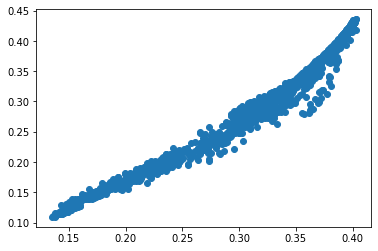

In [0]:
plt.scatter(y_pred[:,1],y_pred[:,2])

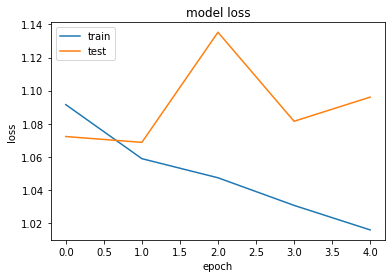

In [0]:
plt.plot(m.history['loss'])
plt.plot(m.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

215350.0

Text(0, 0.5, 'Cumulative P&L')

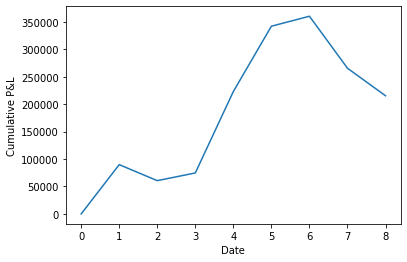

In [0]:
# # Trading simulation using mid-price limit order

ti = int((end_date - start_date) * 0.8 * 780)
ya = np.array(df_final["Pa1"][ti:])
yb = np.array(df_final["Pb1"][ti:])
ym = np.array(df_final["midprice"][ti:])
ya1 = np.array(df_final["Pa1_1min"][ti:])
yb1 = np.array(df_final["Pb1_1min"][ti:])
ybc = np.array(df_final["buy_check"][ti:])
ysc = np.array(df_final["sell_check"][ti:])

dates = int((end_date - start_date) * 0.2)
cumpl = np.zeros((dates + 1,))
date_l = int((780 - time_shift - time_step - last_min)/ slide_step)

book = 0

for i in range(dates):
    pa = ya[i * 780 + time_step: (i + 1) * 780: slide_step]
    pb = yb[i * 780 + time_step: (i + 1) * 780: slide_step]
    pm = ym[i * 780 + time_step: (i + 1) * 780: slide_step]
    pa1 = ya1[i * 780 + time_step: (i + 1) * 780: slide_step]
    pb1 = yb1[i * 780 + time_step: (i + 1) * 780: slide_step]
    bc = ybc[i * 780 + time_step: (i + 1) * 780: slide_step]
    sc = ysc[i * 780 + time_step: (i + 1) * 780: slide_step]

    y_p = y_pred_1[i * date_l : (i+1) * date_l]
    y_t = y_test_1[i * date_l : (i+1) * date_l]

    y_15 = np.zeros((359,))   # command record
    
    for j in range(y_15.shape[0]):
        mid = pm[j]
        ask = pa[j]
        bid = pb[j]

        if j < y_p.shape[0]:
        
          # trigger long signal
          if y_p[j] == 1:       #现在pred有Long的机会
            # check buy price
            flag = False
            if y_15[j] == 2:    #如果15分钟之前给的signal是要卖
              y_15[j] = 0       #Hold，把卖的signal改成持仓
              flag = True       #有头寸
            elif bc[j] == 1:    #如果1分钟内可以买到(以midprice)
              book -= mid       #以midprice买
              flag = True       #有头寸
            # check if can sell at premium
            if flag:                  #如果手上有头寸
              if y_t[j] == 1:         #并且test有Long的机会
                book += (2000 + ask)  #15分钟内必定卖出盈利
              else:
                y_15[j + 15] = 2      #15分钟后给一个平仓-卖的signal
        
          # trigger short signal
          if y_p[j] == 2:
            # check sell price
            flag = False
            if y_15[j] == 1:
              y_15[j] = 0
              flag = True 
            elif sc[j] == 1:
              book += mid
              flag = True
            # check if can buy at discount
            if flag:
              if y_t[j] == 2:
                book -= (bid - 2000)
              else:
                y_15[j + 15] = 1

        # trigger buy to close short position
        if y_15[j] == 1:
          if bc[j] == 1:
            book -= mid
          else:
            book -= pa1[j]
          
        # trigger sell to close long position
        if y_15[j] == 2:
          if sc[j] == 1:
            book += mid
          else:
            book += pb1[j]
    
    cumpl[i + 1] = book


display(book)
plt.plot(np.linspace(0, dates, num = dates + 1), cumpl)
plt.xlabel("Date")
plt.ylabel("Cumulative P&L")

Text(0, 0.5, 'Daily P&L')

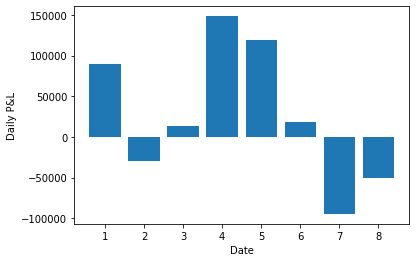

In [0]:
plt.bar(np.linspace(1, dates, num = dates), np.diff(cumpl))
plt.xlabel("Date")
plt.ylabel("Daily P&L")

84200

Text(0, 0.5, 'Cumulative P&L')

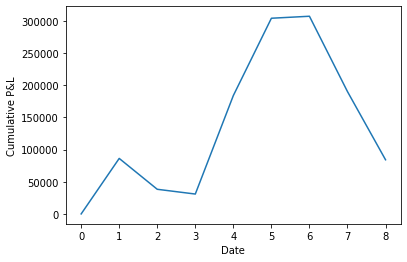

In [0]:
# # Trading simulation using market order

ti = int((end_date - start_date) * 0.8 * 780)
ya = np.array(df_final["Pa1"][ti:])
yb = np.array(df_final["Pb1"][ti:])
ym = np.array(df_final["midprice"][ti:])
ya1 = np.array(df_final["Pa1_1min"][ti:])
yb1 = np.array(df_final["Pb1_1min"][ti:])
ybc = np.array(df_final["buy_check"][ti:])
ysc = np.array(df_final["sell_check"][ti:])

dates = int((end_date - start_date) * 0.2)
cumpl = np.zeros((dates + 1,))
date_l = int((780 - time_shift - time_step - last_min)/ slide_step)

book = 0

for i in range(dates):
    pa = ya[i * 780 + time_step: (i + 1) * 780: slide_step]
    pb = yb[i * 780 + time_step: (i + 1) * 780: slide_step]
    pm = ym[i * 780 + time_step: (i + 1) * 780: slide_step]
    pa1 = ya1[i * 780 + time_step: (i + 1) * 780: slide_step]
    pb1 = yb1[i * 780 + time_step: (i + 1) * 780: slide_step]
    bc = ybc[i * 780 + time_step: (i + 1) * 780: slide_step]
    sc = ysc[i * 780 + time_step: (i + 1) * 780: slide_step]

    y_p = y_pred_1[i * date_l : (i+1) * date_l]
    y_t = y_test_1[i * date_l : (i+1) * date_l]

    y_15 = np.zeros((359,))   # command record
    
    for j in range(y_15.shape[0]):
        mid = pm[j]
        ask = pa[j]
        bid = pb[j]

        if j < y_p.shape[0]:
        
          # trigger long signal
          if y_p[j] == 1:       
            # check buy price
            if y_15[j] == 2:    
              y_15[j] = 0            
            else:    
              book -= ask           
            # check if can sell at premium              
            if y_t[j] == 1:         
              book += (2000 + ask)  
            else:
              y_15[j + 15] = 2      
        
          # trigger short signal
          if y_p[j] == 2:
            # check sell price
            if y_15[j] == 1:
              y_15[j] = 0
            else:
              book += bid
            # check if can buy at discount
            if y_t[j] == 2:
              book -= (bid - 2000)
            else:
              y_15[j + 15] = 1

        # trigger buy to close short position
        if y_15[j] == 1:
          book -= ask

          
        # trigger sell to close long position
        if y_15[j] == 2:
          book += bid
    
    cumpl[i + 1] = book

display(book)
plt.plot(np.linspace(0, dates, num = dates + 1), cumpl)
plt.xlabel("Date")
plt.ylabel("Cumulative P&L")

Text(0, 0.5, 'Daily P&L')

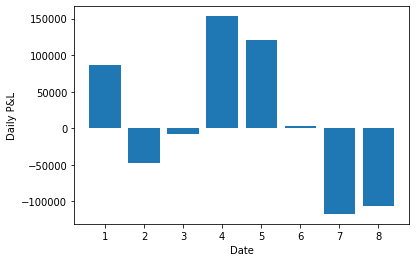

In [0]:
plt.bar(np.linspace(1, dates, num = dates), np.diff(cumpl))
plt.xlabel("Date")
plt.ylabel("Daily P&L")

array([0.69980769, 0.79137821, 0.83128205, 0.85355769, 0.86913462,
       0.88137821, 0.89054487, 0.89689103, 0.90278846, 0.90705128,
       0.91121795, 0.91483974, 0.91804487, 0.92102564, 0.92333333,
       0.92570513, 0.92740385, 0.92971154, 0.93125   , 0.93285256,
       0.93442308, 0.93576923, 0.93711538, 0.93846154, 0.93961538,
       0.94057692, 0.94176282, 0.94278846, 0.94352564, 0.94435897])

array([0.69682692, 0.78695513, 0.82602564, 0.84977564, 0.86544872,
       0.87727564, 0.88669872, 0.89333333, 0.89913462, 0.90413462,
       0.90826923, 0.9124359 , 0.91596154, 0.91958333, 0.92237179,
       0.92403846, 0.92596154, 0.92772436, 0.92948718, 0.93121795,
       0.93246795, 0.9336859 , 0.9350641 , 0.93583333, 0.93737179,
       0.93878205, 0.93971154, 0.94057692, 0.94160256, 0.94253205])

686.6442307692307

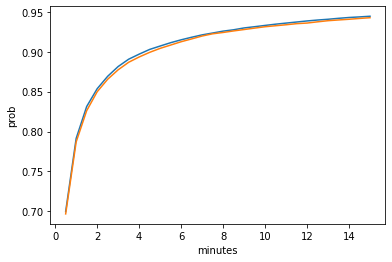

In [0]:
minutes = np.zeros((30,))
prob_buy = np.zeros((30,))
prob_sell = np.zeros((30,))

for i in range(30):
  minutes[i] = (i + 1) * 0.5 
  df_final["exe_min_1min"] = df_final["exe_price_min"].rolling(i+1).min().shift(-(i+1))
  df_final["ss_min_1min"] = df_final["ss_price_min"].rolling(i+1).min().shift(-(i+1))
  df_final["Pa_min_1min"] = df_final["Pa1_min"].rolling(i+1).min().shift(-(i+1))
  df_final["rollmin_1min"] = df_final[["exe_min_1min", "ss_min_1min", "Pa_min_1min"]].min(axis = 1)
  df_final["mid_price"] = (df_final["Pa1"] + df_final["Pb1"]) / 2
  df_final["Vol_check"] = (df_final["rollmin_1min"] <= df_final["mid_price"]) * 1
  prob_buy[i] = np.sum(df_final["Vol_check"]) / len(df_final["Vol_check"])


for i in range(30):
  df_final["exe_max_1min"] = df_final["exe_price_max"].rolling(i+1).max().shift(-(i+1))
  df_final["sb_max_1min"] = df_final["sb_price_max"].rolling(i+1).max().shift(-(i+1))
  df_final["Pb_max_1min"] = df_final["Pb1_max"].rolling(i+1).max().shift(-(i+1))
  df_final["rollmax_1min"] = df_final[["exe_max_1min", "sb_max_1min", "Pb_max_1min"]].max(axis = 1)
  df_final["mid_price"] = (df_final["Pa1"] + df_final["Pb1"]) / 2
  df_final["Vol_check"] = (df_final["rollmax_1min"] >= df_final["mid_price"]) * 1
  prob_sell[i] = np.sum(df_final["Vol_check"]) / len(df_final["Vol_check"])

plt.ylabel('prob')
plt.xlabel('minutes')
plt.plot(minutes, prob_buy)
plt.plot(minutes, prob_sell)
display(prob_buy)
display(prob_sell)
display(np.mean(df_final['Pa1'] - df_final['Pb1']))